In [1]:
import zipfile
import os
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('all')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, classification_report, recall_score
import warnings
from pandas.errors import SettingWithCopyWarning
import joblib
import tensorflow as tf
import os
import torch
from transformers import BertTokenizer, BertModel
import umap
import hdbscan
from sklearn.linear_model import LogisticRegression
from bertopic import BERTopic

uploaded_zip = '/home/abarovic/popeREU/eclipse_platform.zip'
extract_dir = '/home/abarovic/popeREU'
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)
with zipfile.ZipFile(uploaded_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

csv_file = os.path.join(extract_dir, 'eclipse_platform.csv')
fulldata = pd.read_csv(csv_file)

print(fulldata.columns)
print(fulldata.isna().sum())  # Check NaNs in training features

def CreateDuration(dataset):
    dataset['Created_time'] = pd.to_datetime(dataset['Created_time'], utc=True)
    dataset['Resolved_time'] = pd.to_datetime(dataset['Resolved_time'], utc=True)

    # Convert to the desired format
    dataset['Created_time2'] = dataset['Created_time'].dt.strftime('%m/%d/%Y %H:%M')
    dataset['Resolved_time2'] = dataset['Resolved_time'].dt.strftime('%m/%d/%Y %H:%M')

    # Parse the formatted datetime strings back to datetime objects to ensure they are in the correct format
    dataset['Created_time2'] = pd.to_datetime(dataset['Created_time2'], format='%m/%d/%Y %H:%M')
    dataset['Resolved_time2'] = pd.to_datetime(dataset['Resolved_time2'], format='%m/%d/%Y %H:%M')

    # Calculate the duration in hours
    dataset['Duration'] = dataset['Resolved_time2'] - dataset['Created_time2']
    dataset['Duration_hours'] = dataset['Duration'].dt.total_seconds() / 3600

    # Drop the intermediate columns
    dataset.drop(['Created_time2', 'Resolved_time2', 'Duration'], axis=1, inplace=True)

CreateDuration(fulldata)

def NoOutliers(df):
    Q1 = df['Duration_hours'].quantile(0.25)
    Q3 = df['Duration_hours'].quantile(0.75)

    # Calculate the IQR
    IQR = Q3 - Q1

    # Define the lower and upper bounds for filtering outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    df = df[(df['Duration_hours'] >= lower_bound) & (df['Duration_hours'] <= upper_bound)]
    return(df)

#fulldata = NoOutliers(fulldata)

def CreateTimeLabel(df):
    threshold = df['Duration_hours'].quantile(0.70)
    # Create a new column TimeLabel based on the threshold
    df['TimeLabel'] = df['Duration_hours'].apply(lambda x: 'short' if x <= threshold else 'long')
    df = df[df['Resolution'] != 'MOVED']
    #df = df[df['Resolution'] == 'FIXED']
    return df

fulldata = CreateTimeLabel(fulldata)
def RemoveStopWords(dataset):
    #making all the items in the descriptions columns lower
    dataset['Description'] = dataset['Description'].str.lower()
    # Define stop words
    stop_words = set(stopwords.words('english'))
     # Remove stop words
    for index, row in dataset.iterrows():
        # Check if the 'Description' is not NaN
        if isinstance(row['Description'], str):
            words = row['Description'].split()
            final_tokens = [word for word in words if word not in stop_words]
            dataset.at[index, 'Description'] = ' '.join(final_tokens)
    return dataset

fulldata = RemoveStopWords(fulldata)

def Lemmitization(dataset):
    # Initialize the WordNet Lemmatizer
    lemmatizer = WordNetLemmatizer()
    # Function to lemmatize a sentence
    def lemmatize_sentence(sentence):
        words = nltk.word_tokenize(sentence)
        lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in words]  # Lemmatize verbs (default)
        return ' '.join(lemmatized_words)
    dataset['Description'] = dataset['Description'].astype(str)  # Convert all to strings
    # Apply lemmatization to each row in the 'Description' column
    dataset['Description'] = dataset['Description'].apply(lemmatize_sentence)

Lemmitization(fulldata)

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wn.ADJ
    elif treebank_tag.startswith('V'):
        return wn.VERB
    elif treebank_tag.startswith('N'):
        return wn.NOUN
    elif treebank_tag.startswith('R'):
        return wn.ADV
    else:
        return None

# Function to calculate sentiment scores
def CalculateSentimentScores(description):
    tokens = word_tokenize(description)
    tagged_tokens = pos_tag(tokens)
        
    pos_score = 0
    neg_score = 0
    token_count = 0
    for word, tag in tagged_tokens:
        wn_tag = get_wordnet_pos(tag)
        if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
            continue
        
        synsets = list(swn.senti_synsets(word, wn_tag))
        if not synsets:
            continue
        
        # Use the first synset for simplicity
        synset = synsets[0]
        pos_score += synset.pos_score()
        neg_score += synset.neg_score()
        token_count += 1
    
    # Normalize scores by the number of tokens
    if token_count > 0:
        pos_score /= token_count
        neg_score /= token_count
        return pos_score, neg_score

# Apply sentiment score calculation to each description
def CreatePosNegColumns(dataset): 
    dataset[['Pos_Score', 'Neg_Score']] = dataset['Description'].apply(lambda x: pd.Series(CalculateSentimentScores(x)))

CreatePosNegColumns(fulldata)

def EmotionColumn(dataset):
    #Creating a column for binary emotion (positive or negative)
    dataset['Emotion'] = dataset['Pos_Score'] - dataset['Neg_Score']
    
    # Assign labels based on the difference
    dataset['Emotion'] = dataset['Emotion'].apply(lambda x: 'positive' if x > 0 else 'negative')

EmotionColumn(fulldata)

def EmotionalityColumn(dataset):
    dataset['Emotionality'] = dataset['Pos_Score']+ dataset['Neg_Score']

EmotionalityColumn(fulldata)

def Destiny(df):
    # Create a new column 'Destiny' with default value 'Not Fixed'
    df['Destiny'] = 'Not Fixed'
    # Update 'Destiny' based on conditions in 'Resolution' column
    df.loc[df['Resolution'] == 'FIXED', 'Destiny'] = 'Fixed'
    return df

fulldata = Destiny(fulldata)
#print(fulldata['Emotion'].head(100))

def Emotion(df):
    # Fill NaN values with a default value (e.g., 'neutral') before mapping
    df['Emotion'] = df['Emotion'].fillna('neutral')
    # Label Positive emotion as 1, negative as 0, and neutral as -1
    df['Emotion'] = df['Emotion'].map({'positive': 1, 'negative': 0, 'neutral': -1})
    return df

fulldata = Emotion(fulldata)


def Priority(df):
    # Fill NaN values with a default value (e.g., 'P5') before mapping
    df['Priority'] = df['Priority'].fillna('P5')
    # Label Priority Columns numerically
    df['Priority'] = df['Priority'].map({'P1': 1, 'P2': 2, 'P3': 3, 'P4': 4, 'P5': 5})
    return df

fulldata = Priority(fulldata)

def DropDescriptionNA(df):
    df = df[df['Description'] != 'nan']

DropDescriptionNA(fulldata)

def Model(df):
    model = BERTopic(nr_topics=20)

    # Prepare the documents
    docs = df['Description'].fillna('').astype(str).tolist()

    # Fit the model to your data
    topics, probabilities = model.fit_transform(docs)
    #adding a column for predicted topics
    new_docs = df['Description'].fillna('').astype(str).to_list()
    topics, probs = model.transform(new_docs)
    df['Predicted_Topic'] = topics

    # Get topic information
    topic_info = model.get_topic_info()
    print(topic_info)
    # Get words associated with each topic
    topic_words = {topic: model.get_topic(topic) for topic in topic_info.Topic}
    print(topic_words)
    return df

fulldata = Model(fulldata)

print(fulldata.columns)

print(fulldata.columns)
print(fulldata['Emotionality'].head(100))

def SplitData(dataset):
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    trainset, testset = dataset[:train_size], dataset[train_size:]
    return trainset, testset
trainset, testset = SplitData(fulldata)
print("Total items in dataset:", fulldata.shape[0])
print("Total items in trainset:", trainset.shape[0])
print("Total items in testset:", testset.shape[0])

print(trainset.columns)
print(testset.columns)

print(trainset['Emotionality'].head(100))

print("-----------------\n Training Set: \n-----------------")
print(trainset.isna().sum())  # Check NaNs in training features
print("-----------------\n Test Set: \n-----------------")
print(testset.isna().sum())   # Check NaNs in test features


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /home/abarovic/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/abarovic/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/abarovic/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/abarovic/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/abarovic/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]  

Index(['Issue_id', 'Priority', 'Component', 'Duplicated_issue', 'Title',
       'Description', 'Status', 'Resolution', 'Version', 'Created_time',
       'Resolved_time'],
      dtype='object')
Issue_id                0
Priority                0
Component               0
Duplicated_issue    70752
Title                   0
Description           129
Status                  0
Resolution              0
Version                 0
Created_time            0
Resolved_time           0
dtype: int64


/home/abarovic/anaconda3/envs/pope_env/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The curren

    Topic  Count                                               Name  \
0      -1  42069                           -1_file_eclipse_use_line   
1       0  35777                              0_at_00000000_use_new   
2       1   2807                           1_cvs_project_file_patch   
3       2   1846                            2_font_color_fonts_text   
4       3    714                           3_print_console_0303_gtk   
5       4    617                        4_bug_stream_clone_backport   
6       5    425                              5_note_den_hey_please   
7       6    244                       6_sort_column_order_priority   
8       7    132                   7_nan_doublevalue_ve_doubleisnan   
9       8    125  8_platformconfig_registryloader_ljavalangclass...   
10      9     96             9_spinner_value_getselection_selection   
11     10     78                          10_summary_say_see_attach   
12     11     60                 11_partition_equal_return_hashcode   
13    

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Assume SplitData function properly splits your data
trainset, testset = SplitData(fulldata)

# Define features and target
features = ['Emotion', 'Emotionality', 'Priority']
target = 'Duration_hours'

# Handle missing values in features (Fill NaN with median value)
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(trainset[features])
X_test = imputer.transform(testset[features])

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Target variable should remain numeric (do NOT use LabelEncoder)
y_train = trainset[target].fillna(trainset[target].median()).values
y_test = testset[target].fillna(testset[target].median()).values

# Define a Fully Connected Neural Network for Regression
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Regression output
])

# Compile model with MSE loss
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])  # Mean Absolute Error for evaluation

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Evaluate model
y_pred = model.predict(X_test)

# Print Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))


Epoch 1/50


2025-03-06 22:07:25.686871: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4258/4258 [==============================] - 12s 3ms/step - loss: 198688512.0000 - mae: 8678.7129 - val_loss: 55807856.0000 - val_mae: 6510.1196
Epoch 2/50
4258/4258 [==============================] - 12s 3ms/step - loss: 188092720.0000 - mae: 9141.9902 - val_loss: 56801984.0000 - val_mae: 6598.5264
Epoch 3/50
4258/4258 [==============================] - 12s 3ms/step - loss: 187878160.0000 - mae: 9123.4209 - val_loss: 58352464.0000 - val_mae: 6722.6348
Epoch 4/50
4258/4258 [==============================] - 12s 3ms/step - loss: 187931488.0000 - mae: 9128.3467 - val_loss: 56998252.0000 - val_mae: 6620.8838
Epoch 5/50
4258/4258 [==============================] - 12s 3ms/step - loss: 187697456.0000 - mae: 9136.8545 - val_loss: 56347500.0000 - val_mae: 6571.7329
Epoch 6/50
4258/4258 [==============================] - 12s 3ms/step - loss: 187753440.0000 - mae: 9130.5615 - val_loss: 56112736.0000 - val_mae: 6543.8335
Epoch 7/50
4258/4258 [==============================] - 12s 3ms/step - loss

Epoch 1/100
2129/2129 [==============================] - 8s 3ms/step - loss: 2.1465 - mae: 2.6086 - val_loss: 1.9062 - val_mae: 2.3633
Epoch 2/100
2129/2129 [==============================] - 7s 3ms/step - loss: 2.0303 - mae: 2.4905 - val_loss: 1.9408 - val_mae: 2.3952
Epoch 3/100
2129/2129 [==============================] - 7s 3ms/step - loss: 2.0202 - mae: 2.4810 - val_loss: 1.9031 - val_mae: 2.3603
Epoch 4/100
2129/2129 [==============================] - 7s 3ms/step - loss: 2.0125 - mae: 2.4734 - val_loss: 1.9748 - val_mae: 2.4271
Epoch 5/100
2129/2129 [==============================] - 7s 3ms/step - loss: 2.0032 - mae: 2.4638 - val_loss: 1.9022 - val_mae: 2.3596
Epoch 6/100
2129/2129 [==============================] - 7s 3ms/step - loss: 1.9991 - mae: 2.4592 - val_loss: 1.9533 - val_mae: 2.4064
Epoch 7/100
2129/2129 [==============================] - 7s 3ms/step - loss: 1.9939 - mae: 2.4541 - val_loss: 1.9197 - val_mae: 2.3750
Epoch 8/100
2129/2129 [==============================] 

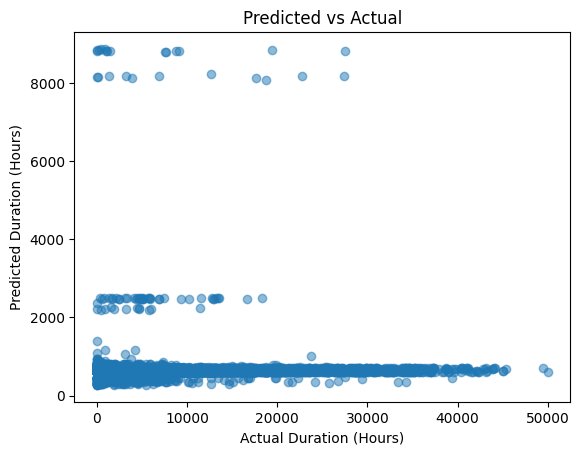

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Assume SplitData function properly splits your data
trainset, testset = SplitData(fulldata)

# Define features and target
features = ['Emotion', 'Emotionality', 'Priority']
target = 'Duration_hours'

# Handle missing values (Fill NaN with median)
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(trainset[features])
X_test = imputer.transform(testset[features])

# Normalize features (Try MinMaxScaler for better neural network performance)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply log transformation to target if necessary (optional, useful for skewed data)
y_train = np.log1p(trainset[target].fillna(trainset[target].median()).values)
y_test = np.log1p(testset[target].fillna(testset[target].median()).values)

# Define an optimized neural network
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],)),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),

    Dense(64),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),

    Dense(32),
    LeakyReLU(alpha=0.1),

    Dense(1, activation='linear')  # Regression output
])

# Compile model with improved loss function and learning rate
model.compile(optimizer=Adam(learning_rate=0.0005),  # Lower learning rate
              loss=Huber(delta=1.0),  # More robust to outliers
              metrics=['mae'])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, 
                    epochs=100,  # More epochs, but early stopping prevents overtraining
                    batch_size=32,  # Increased batch size for stability
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stop])

# Predict and convert back from log space if log transformation was used
y_pred = np.expm1(model.predict(X_test))
y_test_actual = np.expm1(y_test)

# Evaluate model
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("Mean Absolute Error:", mean_absolute_error(y_test_actual, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test_actual, y_pred))

# Plot predictions vs actual values
plt.scatter(y_test_actual, y_pred, alpha=0.5)
plt.xlabel("Actual Duration (Hours)")
plt.ylabel("Predicted Duration (Hours)")
plt.title("Predicted vs Actual")
plt.show()


Epoch 1/100
1491/1491 [==============================] - 6s 4ms/step - loss: 1.6373 - mae: 2.0908 - val_loss: 1.5631 - val_mae: 2.0183
Epoch 2/100
1491/1491 [==============================] - 5s 3ms/step - loss: 1.5148 - mae: 1.9660 - val_loss: 1.5603 - val_mae: 2.0142
Epoch 3/100
1491/1491 [==============================] - 5s 3ms/step - loss: 1.5104 - mae: 1.9606 - val_loss: 1.5684 - val_mae: 2.0215
Epoch 4/100
1491/1491 [==============================] - 5s 3ms/step - loss: 1.5017 - mae: 1.9516 - val_loss: 1.5733 - val_mae: 2.0262
Epoch 5/100
1491/1491 [==============================] - 5s 3ms/step - loss: 1.4982 - mae: 1.9487 - val_loss: 1.5698 - val_mae: 2.0230
Epoch 6/100
1491/1491 [==============================] - 5s 3ms/step - loss: 1.4945 - mae: 1.9438 - val_loss: 1.5641 - val_mae: 2.0168
Epoch 7/100
373/373 [==============================] - 1s 1ms/step
Mean Absolute Error: 575.7511550026173
Mean Squared Error: 984882.9036074739


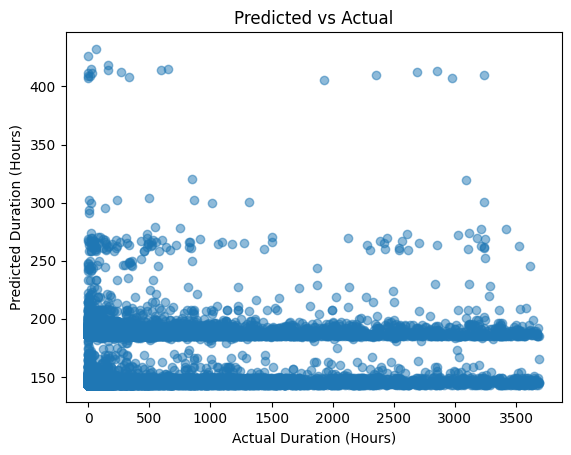

In [4]:
# Filter dataset to include only entries where TimeLabel is 'short'
filtered_data = fulldata[fulldata['TimeLabel'] == 'short']

# Assume SplitData function properly splits your data
trainset, testset = SplitData(filtered_data)

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Assume SplitData function properly splits your data
trainset, testset = SplitData(filtered_data)

# Define features and target
features = ['Emotion', 'Emotionality', 'Priority']
target = 'Duration_hours'

# Handle missing values (Fill NaN with median)
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(trainset[features])
X_test = imputer.transform(testset[features])

# Normalize features (Try MinMaxScaler for better neural network performance)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply log transformation to target if necessary (optional, useful for skewed data)
y_train = np.log1p(trainset[target].fillna(trainset[target].median()).values)
y_test = np.log1p(testset[target].fillna(testset[target].median()).values)

# Define an optimized neural network
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],)),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),

    Dense(64),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),

    Dense(32),
    LeakyReLU(alpha=0.1),

    Dense(1, activation='linear')  # Regression output
])

# Compile model with improved loss function and learning rate
model.compile(optimizer=Adam(learning_rate=0.0005),  # Lower learning rate
              loss=Huber(delta=1.0),  # More robust to outliers
              metrics=['mae'])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, 
                    epochs=100,  # More epochs, but early stopping prevents overtraining
                    batch_size=32,  # Increased batch size for stability
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stop])

# Predict and convert back from log space if log transformation was used
y_pred = np.expm1(model.predict(X_test))
y_test_actual = np.expm1(y_test)

# Evaluate model
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("Mean Absolute Error:", mean_absolute_error(y_test_actual, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test_actual, y_pred))

# Plot predictions vs actual values
plt.scatter(y_test_actual, y_pred, alpha=0.5)
plt.xlabel("Actual Duration (Hours)")
plt.ylabel("Predicted Duration (Hours)")
plt.title("Predicted vs Actual")
plt.show()
